# Toy example

Original notebook by Alexander Held, edited for the MadMiner repository by Johann Brehmer, Irina Espejo, Felix Kling, and Kyle Cranmer 2018-2019.

In this notebook, we use a simple toy example to demonstrate the machine learning and inference algorithms in MadMiner. This allows us to skip many of the more technical steps, and there's no dependency on MadGraph, Pythia, or Delphes.

What this tutorial does not do, is explaining the inference methods. To understand what's happening, please have a look at ["Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00013), which will explain the basic idea in just a few pages. If you really want to get down to the dirty details, ["A Guide to Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00020) has you covered.

## Preparations

In [1]:
import os
import logging
import numpy as np
from scipy.stats import norm
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import math

%matplotlib inline

from madminer.ml.ensemble import Ensemble
from madminer.ml import ParameterizedRatioEstimator, ScoreEstimator, BayesianScoreEstimator, HeteroskedasticScoreEstimator, RepulsiveEnsembleScoreEstimator

In [2]:
if not os.path.exists("data"):
    os.makedirs("data")

MadMiner uses the Python `logging` module to provide additional information and debugging output. You can choose how much of this output you want to see by switching the level in the following lines to `logging.DEBUG` or `logging.WARNING`.

In [3]:
# MadMiner output
logging.basicConfig(
    format="%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s",
    datefmt="%H:%M",
    level=logging.INFO,
)

# Output of all other modules (e.g. matplotlib)
for key in logging.Logger.manager.loggerDict:
    if "madminer" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)

## 1. A toy simulator

Our simulator depends on just one parameter `theta` and produces one-dimensional observables `x`. It is characterized by one latent variable `z`. "Running" the simulator consists of two steps:
- "Hard process": a value of `z` is drawn from a normal distribution, where the mean depends on `theta`. 
- "Detector": a value for `x` is drawn from a normal distribution with mean equal to `z`. There is no explicit dependence on `theta`.

As in the particle physics case, we assume that we can calculate the joint likelihood ratio `r(x, z | theta0, theta1)` as well as the joint score `t(x, z | theta)`, which depend explicitly on `z` (and where the "detector" part cancels).

Here are some general settings (feel free to play with them): 

In [4]:
z_std = 2.0
x_std = 1.0

The following function runs the simulator for a value of `theta` and calculates the joint likelihood ratio between `theta0` and `theta1` as well as the joint score at `theta_score`:

In [5]:
def simulate(theta, theta0=None, theta1=None, theta_score=None, npoints=None):
    # Draw latent variables z
    z = np.random.normal(loc=theta, scale=z_std, size=npoints)

    # Draw observables x
    x = np.random.normal(loc=z, scale=x_std, size=None)

    # Calculate joint likelihood ratio and joint score
    if theta0 is not None and theta1 is not None:
        r_xz = norm(loc=theta0, scale=z_std).pdf(z) / norm(loc=theta1, scale=z_std).pdf(z)
    else:
        r_xz = None

    if theta_score is not None:
        t_xz = 2*(z - theta_score) / z_std**2
    else:
        t_xz = None

    return x, r_xz, t_xz

Usually the likelihood function `p(x|theta)` is intractable, but in this toy example it is just given by the convolution of two Gaussians, which is again a Gaussian. We will use this to validate the results later:

In [6]:
def calculate_likelihood_ratio(x, theta0, theta1=0.0):
    combined_std = (z_std**2 + x_std**2) ** 0.5
    r_x = norm(loc=theta0, scale=combined_std).pdf(x) / norm(loc=theta1, scale=combined_std).pdf(x)
    return r_x

## repulsive ensemble

In [7]:
class StackedLinear(nn.Module):
    """
    Efficient implementation of linear layers for ensembles of networks
    """
    def __init__(self, in_features, out_features, channels):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.channels = channels
        self.weight = nn.Parameter(torch.empty((channels, out_features, in_features)))
        self.bias = nn.Parameter(torch.empty((channels, out_features)))
        self.reset_parameters()

    def reset_parameters(self):
        for i in range(self.channels):
            torch.nn.init.kaiming_uniform_(self.weight[i], a=math.sqrt(5))
            fan_in, _ = torch.nn.init._calculate_fan_in_and_fan_out(self.weight[i])
            bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
            torch.nn.init.uniform_(self.bias[i], -bound, bound)

    def forward(self, input):
        return torch.baddbmm(self.bias[:,None,:], input, self.weight.transpose(1,2))

def kernel(x, y):
    """
    RBF kernel with median estimator
    """
    channels = len(x)
    dnorm2 = (x.reshape(channels,1,-1) - y.reshape(1,channels,-1)).square().sum(dim=2)
    sigma = torch.quantile(dnorm2.detach(), 0.5) / (2 * math.log(channels + 1))
    return torch.exp(- dnorm2 / (2*sigma))

In [8]:
def train_repulsive_ensemble(x, y):
    channels = 100
    iterations = 1000
    n_samples = len(x)
    prior_width = 1.

    model = nn.Sequential(
        StackedLinear(1, 10, channels),
        nn.ReLU(),
        StackedLinear(10, 10, channels),
        nn.ReLU(),
        StackedLinear(10, 2, channels),
    )
    opt = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1 / (2*n_samples*prior_width**2))
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, iterations)

    xt = torch.tensor(x[None,:,None], dtype=torch.float32).expand(channels,-1,-1)
    print("dim of x:", x.shape)
    print("dim of xt:", xt.shape, x[None,:,None].shape)
    yt = torch.tensor(y[None,:], dtype=torch.float32).expand(channels,-1)

    for i in range(iterations):
        h = model(xt)
        mu, log_sigma2 = h[:,:,0], h[:,:,1]
        
        # Heteroscedastic regression loss
        reg = 0.5 * ((yt - mu)**2 / log_sigma2.exp() + log_sigma2)
        
        # repulsive ensemble loss
        k = kernel(reg, reg.detach())
        reg_mean, reg_std = reg.mean(dim=1), reg.std(dim=1)
        loss = torch.sum(reg_mean + (k.sum(dim=1) / k.detach().sum(dim=1) - 1) / len(x), dim=0)
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        sched.step()
        print(f"iteration {i}: loss={loss}")
        if i % 100 == 0:
            print(f"mean={reg_mean.mean().item():.4f}, std={reg_mean.std().item():.4f}, " +
                f"min={reg_mean.min().item():.4f}, max={reg_mean.max().item():.4f}")

    return model

## 2. Run the simulation and generate training data

In [9]:
# number of parameter points to train
n_param_points = 1000

# numerator, uniform prior
theta0 = np.zeros(shape=n_param_points)

# Sample from theta0
x_from_theta0, r_xz_from_theta0, t_xz_from_theta0 = simulate(theta0, theta0, theta0, theta0)

# Combine results and reshape
# x_train = np.hstack((x_from_theta0, x_from_theta1)).reshape(-1, 1)
# r_xz_train = np.hstack((r_xz_from_theta0, r_xz_from_theta1)).reshape(-1, 1)
# t_xz_train = np.hstack((t_xz_from_theta0, t_xz_from_theta1)).reshape(-1, 1)
# y_train = np.hstack((np.zeros_like(x_from_theta0), np.ones_like(np.ones_like(x_from_theta1)))).reshape(-1, 1)
# theta0_train = np.hstack((theta0, theta0)).reshape(-1, 1)
x_train = x_from_theta0
t_xz_train = t_xz_from_theta0

# Save to file
np.save("data/x_train.npy", x_train)
np.save("data/t_xz_train.npy", t_xz_train)

In [10]:
def calculate_true_score(x, theta):
    combined_std = (z_std**2 + x_std**2) ** 0.5
    r_x = 2*(x - theta)/combined_std**2
    return r_x

## 3. Model training

In [11]:
repulsive_ensemble = train_repulsive_ensemble(x_train, t_xz_train)

dim of x: (1000,)
dim of xt: torch.Size([100, 1000, 1]) (1, 1000, 1)
iteration 0: loss=62.559818267822266
mean=0.6256, std=0.2056, min=0.3334, max=1.6244
iteration 1: loss=53.17708969116211
iteration 2: loss=46.01601791381836
iteration 3: loss=40.25789260864258
iteration 4: loss=35.397674560546875
iteration 5: loss=31.134536743164062
iteration 6: loss=27.267852783203125
iteration 7: loss=23.68348503112793
iteration 8: loss=20.30522346496582
iteration 9: loss=17.07701873779297
iteration 10: loss=13.943774223327637
iteration 11: loss=10.891157150268555
iteration 12: loss=7.973759651184082
iteration 13: loss=5.25588321685791
iteration 14: loss=2.7965569496154785
iteration 15: loss=0.49847012758255005
iteration 16: loss=-1.7481296062469482
iteration 17: loss=-3.910600185394287
iteration 18: loss=-5.972431182861328
iteration 19: loss=-7.937763214111328
iteration 20: loss=-9.862092971801758
iteration 21: loss=-11.639566421508789
iteration 22: loss=-13.299283981323242
iteration 23: loss=-14.8

In [22]:
# import cProfile

repulsive_ensemble_sally = RepulsiveEnsembleScoreEstimator(n_hidden=(10, 10))

# cProfile.run("""
repulsive_ensemble_sally.train(
    method="repulsive_ensemble_sally",
    x="data/x_train.npy",
    t_xz="data/t_xz_train.npy",
    n_epochs=1000,
)
# """, "trainstats")
repulsive_ensemble_sally.save("models/repulsive_ensemble_sally")

11:53 madminer.ml.score    INFO    Starting training
11:53 madminer.ml.score    INFO      Batch size:             128
11:53 madminer.ml.score    INFO      Optimizer:              amsgrad
11:53 madminer.ml.score    INFO      Epochs:                 1000
11:53 madminer.ml.score    INFO      Learning rate:          0.001 initially, decaying to 0.0001
11:53 madminer.ml.score    INFO      Validation split:       0.25
11:53 madminer.ml.score    INFO      Early stopping:         True
11:53 madminer.ml.score    INFO      Scale inputs:           True
11:53 madminer.ml.score    INFO      Shuffle labels          False
11:53 madminer.ml.score    INFO      Samples:                all
11:53 madminer.ml.score    INFO    Loading training data
11:53 madminer.utils.vario INFO      Loading data/x_train.npy into RAM
11:53 madminer.utils.vario INFO      Loading data/t_xz_train.npy into RAM
11:53 madminer.ml.score    INFO    Found 1000 samples with 1 parameters and 1 observables
11:53 madminer.ml.base     I

torch.backends.mps.is_available() True False


11:53 madminer.utils.ml.tr INFO      Epoch  50: train loss -28.48284 (repulsive_ensemble_loss: -28.483)
11:53 madminer.utils.ml.tr INFO                 val. loss  -35.34294 (repulsive_ensemble_loss: -35.343)
11:54 madminer.utils.ml.tr INFO      Epoch 100: train loss -30.27172 (repulsive_ensemble_loss: -30.272)
11:54 madminer.utils.ml.tr INFO                 val. loss  -35.71913 (repulsive_ensemble_loss: -35.719)
11:54 madminer.utils.ml.tr INFO      Epoch 150: train loss -30.95169 (repulsive_ensemble_loss: -30.952)
11:54 madminer.utils.ml.tr INFO                 val. loss  -35.84366 (repulsive_ensemble_loss: -35.844)
11:54 madminer.utils.ml.tr INFO      Epoch 200: train loss -31.38203 (repulsive_ensemble_loss: -31.382)
11:54 madminer.utils.ml.tr INFO                 val. loss  -36.07674 (repulsive_ensemble_loss: -36.077)
11:54 madminer.utils.ml.tr INFO      Epoch 250: train loss -31.75161 (repulsive_ensemble_loss: -31.752)
11:54 madminer.utils.ml.tr INFO                 val. loss  -35.9

In [21]:
sally = ScoreEstimator(n_hidden=(20, 20))

sally.train(
    method="sally",
    x="data/x_train.npy",
    t_xz="data/t_xz_train.npy",
    n_epochs=100
)

sally.save("models/sally")

11:53 madminer.ml.score    INFO    Starting training
11:53 madminer.ml.score    INFO      Batch size:             128
11:53 madminer.ml.score    INFO      Optimizer:              amsgrad
11:53 madminer.ml.score    INFO      Epochs:                 100
11:53 madminer.ml.score    INFO      Learning rate:          0.001 initially, decaying to 0.0001
11:53 madminer.ml.score    INFO      Validation split:       0.25
11:53 madminer.ml.score    INFO      Early stopping:         True
11:53 madminer.ml.score    INFO      Scale inputs:           True
11:53 madminer.ml.score    INFO      Shuffle labels          False
11:53 madminer.ml.score    INFO      Samples:                all
11:53 madminer.ml.score    INFO    Loading training data
11:53 madminer.utils.vario INFO      Loading data/x_train.npy into RAM
11:53 madminer.utils.vario INFO      Loading data/t_xz_train.npy into RAM
11:53 madminer.ml.score    INFO    Found 1000 samples with 1 parameters and 1 observables
11:53 madminer.ml.base     IN

torch.backends.mps.is_available() True False


11:53 madminer.utils.ml.tr INFO      Epoch  40: train loss  0.21156 (mse_score:  0.212)
11:53 madminer.utils.ml.tr INFO                 val. loss   0.18470 (mse_score:  0.185)
11:53 madminer.utils.ml.tr INFO      Epoch  45: train loss  0.20976 (mse_score:  0.210)
11:53 madminer.utils.ml.tr INFO                 val. loss   0.18381 (mse_score:  0.184)
11:53 madminer.utils.ml.tr INFO      Epoch  50: train loss  0.20876 (mse_score:  0.209)
11:53 madminer.utils.ml.tr INFO                 val. loss   0.18286 (mse_score:  0.183)
11:53 madminer.utils.ml.tr INFO      Epoch  55: train loss  0.20859 (mse_score:  0.209)
11:53 madminer.utils.ml.tr INFO                 val. loss   0.18154 (mse_score:  0.182)
11:53 madminer.utils.ml.tr INFO      Epoch  60: train loss  0.20728 (mse_score:  0.207)
11:53 madminer.utils.ml.tr INFO                 val. loss   0.18188 (mse_score:  0.182)
11:53 madminer.utils.ml.tr INFO      Epoch  65: train loss  0.20656 (mse_score:  0.207)
11:53 madminer.utils.ml.tr INFO 

In [33]:
n_estimators = 100
estimators = [
    ScoreEstimator(n_hidden=(20, 20)) for i in range(n_estimators)
]
ensemble = Ensemble(estimators)
for i, _ in enumerate(estimators):
    ensemble.train_one(i,
        method="sally",
        x="data/x_train.npy",
        t_xz="data/t_xz_train.npy",
        n_epochs=100,
    )
    estimators[i].save(f"models/sally_{i}")

ensemble.save(f"models/sally_ensemble")

09:44 madminer.ml.score    INFO    Starting training
09:44 madminer.ml.score    INFO      Batch size:             128
09:44 madminer.ml.score    INFO      Optimizer:              amsgrad
09:44 madminer.ml.score    INFO      Epochs:                 100
09:44 madminer.ml.score    INFO      Learning rate:          0.001 initially, decaying to 0.0001
09:44 madminer.ml.score    INFO      Validation split:       0.25
09:44 madminer.ml.score    INFO      Early stopping:         True
09:44 madminer.ml.score    INFO      Scale inputs:           True
09:44 madminer.ml.score    INFO      Shuffle labels          False
09:44 madminer.ml.score    INFO      Samples:                all
09:44 madminer.ml.score    INFO    Loading training data
09:44 madminer.utils.vario INFO      Loading data/x_train.npy into RAM
09:44 madminer.utils.vario INFO      Loading data/t_xz_train.npy into RAM
09:44 madminer.ml.score    INFO    Found 1000 samples with 1 parameters and 1 observables
09:44 madminer.ml.base     IN

09:44 madminer.utils.ml.tr INFO      Epoch   5: train loss  0.66197 (mse_score:  0.662)
09:44 madminer.utils.ml.tr INFO                 val. loss   0.61734 (mse_score:  0.617)
09:44 madminer.utils.ml.tr INFO      Epoch  10: train loss  0.29443 (mse_score:  0.294)
09:44 madminer.utils.ml.tr INFO                 val. loss   0.30954 (mse_score:  0.310)
09:44 madminer.utils.ml.tr INFO      Epoch  15: train loss  0.20668 (mse_score:  0.207)
09:44 madminer.utils.ml.tr INFO                 val. loss   0.26438 (mse_score:  0.264)
09:44 madminer.utils.ml.tr INFO      Epoch  20: train loss  0.20213 (mse_score:  0.202)
09:44 madminer.utils.ml.tr INFO                 val. loss   0.26666 (mse_score:  0.267)
09:44 madminer.utils.ml.tr INFO      Epoch  25: train loss  0.20115 (mse_score:  0.201)
09:44 madminer.utils.ml.tr INFO                 val. loss   0.26553 (mse_score:  0.266)
09:44 madminer.utils.ml.tr INFO      Epoch  30: train loss  0.19958 (mse_score:  0.200)
09:44 madminer.utils.ml.tr INFO 

We can also try a little bit of mixing and matching -- let's train a model with CARL first and then with ALICES:

In [18]:
heteroskedastic_sally = HeteroskedasticScoreEstimator(n_hidden=(20, 20))

heteroskedastic_sally.train(
    method="heteroskedastic_sally",
    x="data/x_train.npy",
    t_xz="data/t_xz_train.npy",
    n_epochs=100,
)

heteroskedastic_sally.save("models/heteroskedastic_sally")

16:39 madminer.ml.score    INFO    Starting training
16:39 madminer.ml.score    INFO      Batch size:             128
16:39 madminer.ml.score    INFO      Optimizer:              amsgrad
16:39 madminer.ml.score    INFO      Epochs:                 100
16:39 madminer.ml.score    INFO      Learning rate:          0.001 initially, decaying to 0.0001
16:39 madminer.ml.score    INFO      Validation split:       0.25
16:39 madminer.ml.score    INFO      Early stopping:         True
16:39 madminer.ml.score    INFO      Scale inputs:           True
16:39 madminer.ml.score    INFO      Shuffle labels          False
16:39 madminer.ml.score    INFO      Samples:                all
16:39 madminer.ml.score    INFO    Loading training data
16:39 madminer.utils.vario INFO      Loading data/x_train.npy into RAM
16:39 madminer.utils.vario INFO      Loading data/t_xz_train.npy into RAM
16:39 madminer.ml.score    INFO    Found 1000 samples with 1 parameters and 1 observables
16:39 madminer.ml.base     IN

In [21]:
bayes_sally = BayesianScoreEstimator(n_hidden=(20, 20))

bayes_sally.train(
    method="bayesian_sally",
    x="data/x_train.npy",
    t_xz="data/t_xz_train.npy",
    n_epochs=100,
)

bayes_sally.save("models/bayes_sally")

11:46 madminer.ml.score    INFO    Starting training
11:46 madminer.ml.score    INFO      Batch size:             128
11:46 madminer.ml.score    INFO      Optimizer:              amsgrad
11:46 madminer.ml.score    INFO      Epochs:                 100
11:46 madminer.ml.score    INFO      Learning rate:          0.001 initially, decaying to 0.0001
11:46 madminer.ml.score    INFO      Validation split:       0.25
11:46 madminer.ml.score    INFO      Early stopping:         True
11:46 madminer.ml.score    INFO      Scale inputs:           True
11:46 madminer.ml.score    INFO      Shuffle labels          False
11:46 madminer.ml.score    INFO      Samples:                all
11:46 madminer.ml.score    INFO    Loading training data
11:46 madminer.utils.vario INFO      Loading data/x_train.npy into RAM
11:46 madminer.utils.vario INFO      Loading data/t_xz_train.npy into RAM
11:46 madminer.ml.score    INFO    Found 1000 samples with 1 parameters and 1 observables
11:46 madminer.ml.base     IN

## 5. Evaluation

It's time to evaluate our likelihood ratio estimators!

This is the expected log likelihood ratio over parameter space:

## Score evaluation

In [24]:
n_param_points_test = 10000  # number of parameter points to test
theta_test = 0.0 * np.zeros(shape=n_param_points_test).reshape(-1, 1)
x_test, _, _ = simulate(theta_test)
x_test = np.sort(x_test, axis=0)

np.save("data/x_test.npy", x_test)

In [13]:
xx = torch.linspace(x_test.min(), x_test.max(), 1000)
channels = 100
with torch.no_grad():
    mus = repulsive_ensemble(xx[None,:,None].expand(channels,-1,-1))[:,:,0]
repulsive_ensemble_means = mus.mean(dim=0).numpy()
repulsive_ensemble_stds = mus.std(dim=0).numpy()

In [14]:
sally = ScoreEstimator()
sally.load("models/sally")

t_hat_sally = sally.evaluate(
    theta=np.array([0]),
    x="data/x_test.npy",
)

10:57 madminer.ml.base     INFO    Loading model from models/sally


10:57 madminer.utils.vario INFO      Loading data/x_test.npy into RAM


In [27]:
sally.calculate_fisher_information(x_test)

11:56 madminer.ml.base     INFO    Loading evaluation data


11:56 madminer.ml.base     INFO    Calculating Fisher information


(10000,) (10000, 1)


array([[0.74702925]])

In [17]:
repulsive_ensemble_sally = RepulsiveEnsembleScoreEstimator()
repulsive_ensemble_sally.load("models/repulsive_ensemble_sally")

t_hat_repulsive_ensemble_sally, t_hat_sig_repulsive_ensemble_sally  = repulsive_ensemble_sally.evaluate(
    theta=np.array([0]),
    x="data/x_test.npy",
)

10:58 madminer.ml.base     INFO    Loading model from models/repulsive_ensemble_sally
10:58 madminer.utils.vario INFO      Loading data/x_test.npy into RAM


output shape: torch.Size([100, 10000])


In [25]:
repulsive_ensemble_sally.calculate_fisher_information(x_test)

11:54 madminer.ml.score    INFO    Loading evaluation data


11:54 madminer.ml.score    INFO    Calculating Fisher information


output shape: torch.Size([100, 10000])
(10000,) (10000,) (10000,)


ValueError: einstein sum subscripts string contains too many subscripts for operand 1

In [34]:
sally_ensemble = Ensemble()
sally_ensemble.load("models/sally_ensemble")

t_hat_sally_ensemble, _, t_hat_sig_sally_ensemble = sally_ensemble.evaluate_score(
    # theta=np.array([0]),
    theta=0,
    x="data/x_test.npy",
    calculate_covariance=False,
    calculate_sigma=True
)
t_hat_sally_ensemble = t_hat_sally_ensemble.flatten()
t_hat_sig_sally_ensemble = t_hat_sig_sally_ensemble.flatten()

09:45 madminer.ml.ensemble INFO    Found score ensemble with 100 estimators
09:45 madminer.ml.base     INFO    Loading model from models/sally_ensemble/estimator_0
09:45 madminer.ml.base     INFO    Loading model from models/sally_ensemble/estimator_1
09:45 madminer.ml.base     INFO    Loading model from models/sally_ensemble/estimator_2
09:45 madminer.ml.base     INFO    Loading model from models/sally_ensemble/estimator_3
09:45 madminer.ml.base     INFO    Loading model from models/sally_ensemble/estimator_4
09:45 madminer.ml.base     INFO    Loading model from models/sally_ensemble/estimator_5
09:45 madminer.ml.base     INFO    Loading model from models/sally_ensemble/estimator_6
09:45 madminer.ml.base     INFO    Loading model from models/sally_ensemble/estimator_7
09:45 madminer.ml.base     INFO    Loading model from models/sally_ensemble/estimator_8
09:45 madminer.ml.base     INFO    Loading model from models/sally_ensemble/estimator_9
09:45 madminer.ml.base     INFO    Loading m

09:45 madminer.ml.base     INFO    Loading model from models/sally_ensemble/estimator_18
09:45 madminer.ml.base     INFO    Loading model from models/sally_ensemble/estimator_19
09:45 madminer.ml.base     INFO    Loading model from models/sally_ensemble/estimator_20
09:45 madminer.ml.base     INFO    Loading model from models/sally_ensemble/estimator_21
09:45 madminer.ml.base     INFO    Loading model from models/sally_ensemble/estimator_22
09:45 madminer.ml.base     INFO    Loading model from models/sally_ensemble/estimator_23
09:45 madminer.ml.base     INFO    Loading model from models/sally_ensemble/estimator_24
09:45 madminer.ml.base     INFO    Loading model from models/sally_ensemble/estimator_25
09:45 madminer.ml.base     INFO    Loading model from models/sally_ensemble/estimator_26
09:45 madminer.ml.base     INFO    Loading model from models/sally_ensemble/estimator_27
09:45 madminer.ml.base     INFO    Loading model from models/sally_ensemble/estimator_28
09:45 madminer.ml.bas

In [23]:
bayes_sally = BayesianScoreEstimator()
bayes_sally.load("models/bayes_sally")

t_hat_bayes_sally, t_hat_sig_bayes_sally, t_hat_sig_stoch_bayes_sally, t_hat_sig_tot_bayes_sally = bayes_sally.evaluate(
    theta=np.array([0]),
    x="data/x_test.npy",
)
t_hat_bayes_sally = t_hat_bayes_sally.flatten()
t_hat_sig_bayes_sally = t_hat_sig_bayes_sally.flatten()
t_hat_sig_bayes_sally = np.sqrt(t_hat_sig_bayes_sally)

09:38 madminer.ml.base     INFO    Loading model from models/bayes_sally
09:38 madminer.utils.vario INFO      Loading data/x_test.npy into RAM


In [24]:
t_hat_sig_bayes_sally

array([0.14513262, 0.1444854 , 0.14441034, ..., 0.14643821, 0.14666186,
       0.14672422], dtype=float32)

In [25]:
t_hat_sig_tot_bayes_sally

array([0.77048206, 0.7699351 , 0.7697877 , ..., 0.8074022 , 0.80827147,
       0.80848163], dtype=float32)

In [26]:
t_hat_sig_stoch_bayes_sally

array([0.77019405, 0.769652  , 0.7695052 , ..., 0.8071174 , 0.80798525,
       0.808195  ], dtype=float32)

In [19]:
heteroskedastic_sally = HeteroskedasticScoreEstimator()
heteroskedastic_sally.load("models/heteroskedastic_sally")

t_hat_heteroskedastic_sally, t_hat_sig_heteroskedastic_sally, t_hat_sig_stoch_heteroskedastic_sally, t_hat_sig_tot_heteroskedastic_sally = heteroskedastic_sally.evaluate(
    theta=np.array([0]),
    x="data/x_test.npy",
)
t_hat_heteroskedastic_sally = t_hat_heteroskedastic_sally.flatten()
t_hat_sig_heteroskedastic_sally = t_hat_sig_heteroskedastic_sally.flatten()
t_hat_sig_heteroskedastic_sally = np.sqrt(t_hat_sig_heteroskedastic_sally)

09:37 madminer.ml.base     INFO    Loading model from models/heteroskedastic_sally
09:37 madminer.utils.vario INFO      Loading data/x_test.npy into RAM


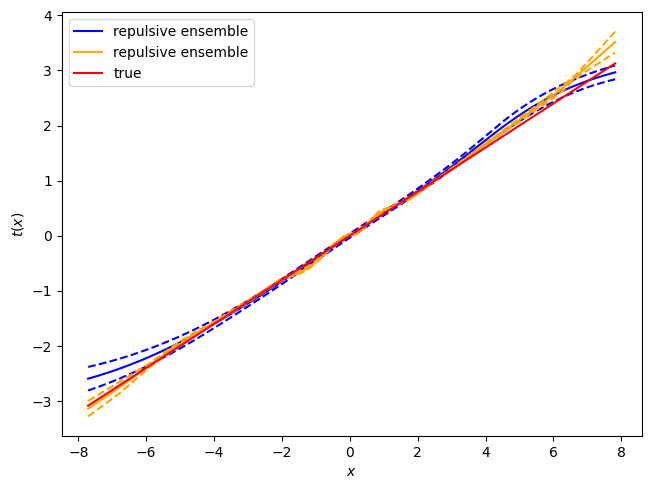

In [35]:
x = np.load("data/x_test.npy")
x = np.sort(x)
t_hat_true = calculate_true_score(x, 0)

fig = plt.figure()

plt.plot(x, t_hat_repulsive_ensemble_sally, c='b', label='repulsive ensemble')
plt.plot(x, t_hat_repulsive_ensemble_sally - t_hat_sig_repulsive_ensemble_sally, c='b', ls='--')
plt.plot(x, t_hat_repulsive_ensemble_sally + t_hat_sig_repulsive_ensemble_sally, c='b', ls='--')

plt.plot(xx.numpy(), repulsive_ensemble_means, c='orange', label='repulsive ensemble')
plt.plot(xx.numpy(), repulsive_ensemble_means - repulsive_ensemble_stds, c='orange', ls='--')
plt.plot(xx.numpy(), repulsive_ensemble_means + repulsive_ensemble_stds, c='orange', ls='--')

plt.plot(x, t_hat_true, c='r', label='true')

plt.legend()

plt.tight_layout()
plt.xlabel(r"$x$")
plt.ylabel(r"$t(x)$")
plt.show()

### Toy model

$p(z|\theta) = \mathcal{N}(z | \theta, \sigma_z = 2)$

$p(x|z) = \mathcal{N}(x | z,\sigma_x = 1)$

true likelihood ratio: $r(x|\theta,\theta_0) = \frac{\mathcal{N}(x | \theta, \sqrt{\sigma_z^2 + \sigma_x^2})}{\mathcal{N}(x | \theta_0, \sqrt{\sigma_z^2 + \sigma_x^2})}$

true score: $t(x|\theta) = 2 \frac{x-\theta}{\sqrt{\sigma_z^2 + \sigma_x^2}}$

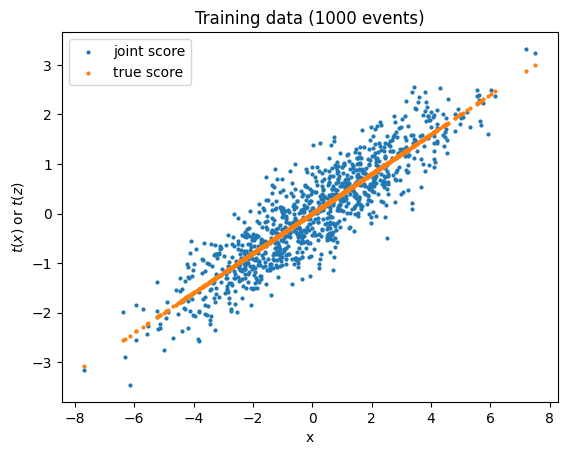

In [32]:
fig, ax = plt.subplots()

plt.scatter(x_train, t_xz_train, label='joint score', s=4)
plt.scatter(x_train, calculate_true_score(x_train, 0.0), label='true score', s=4)
plt.title("Training data (1000 events)")
plt.xlabel(r'x')
plt.ylabel(r'$t(x)$ or $t(z)$')
plt.legend()
plt.show()

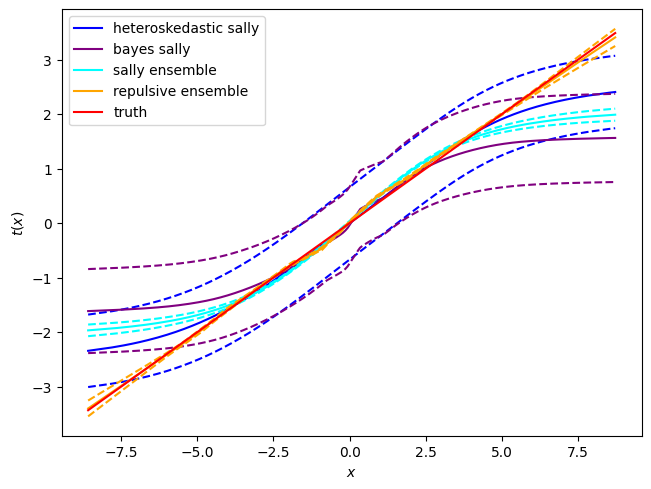

In [35]:
x = np.load("data/x_test.npy")
x = np.sort(x)
t_hat_true = calculate_true_score(x, 0)

fig = plt.figure()

plt.plot(x, t_hat_heteroskedastic_sally,                                   c='b', label='heteroskedastic sally')
plt.plot(x, t_hat_heteroskedastic_sally - t_hat_sig_tot_heteroskedastic_sally, c='b', ls='--')
plt.plot(x, t_hat_heteroskedastic_sally + t_hat_sig_tot_heteroskedastic_sally, c='b', ls='--')
plt.plot(x, t_hat_bayes_sally,                         c='purple', label='bayes sally')
plt.plot(x, t_hat_bayes_sally + t_hat_sig_tot_bayes_sally, c='purple', ls='--')
plt.plot(x, t_hat_bayes_sally - t_hat_sig_tot_bayes_sally, c='purple', ls='--')
# plt.plot(x, t_hat_sally.flatten(), c='darkgreen', label='sally')
plt.plot(x, t_hat_sally_ensemble, c='cyan', label='sally ensemble')
plt.plot(x, t_hat_sally_ensemble - t_hat_sig_sally_ensemble, c='cyan', ls='--')
plt.plot(x, t_hat_sally_ensemble + t_hat_sig_sally_ensemble, c='cyan', ls='--')
plt.plot(xx.numpy(), repulsive_ensemble_means, c='orange', label='repulsive ensemble')
plt.plot(xx.numpy(), repulsive_ensemble_means - repulsive_ensemble_stds, c='orange', ls='--')
plt.plot(xx.numpy(), repulsive_ensemble_means + repulsive_ensemble_stds, c='orange', ls='--')
plt.plot(x, t_hat_true, c='r', label='truth')

plt.legend()

plt.tight_layout()
plt.xlabel(r"$x$")
plt.ylabel(r"$t(x)$")
plt.show()